In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' to suppress all messages
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import random
import joblib
label_encoder = LabelEncoder()
pd.options.mode.chained_assignment = None


In [12]:
label_path = './data/data_by_table/pre_24h_data_v6.csv'
flag_data_path = './data/data_by_table/ground_truth.csv'
raw_data_path = './data/data_by_table/pre_24h_data_1217.csv'
mode_data_path = './data/data_by_table/pre_24_merged_30_rows_12_07.csv'

data_df = pd.read_csv(raw_data_path)
flag_data_df = pd.read_csv(flag_data_path)
label_df = pd.read_csv(label_path)
mode_df = pd.read_csv(mode_data_path)
data_df['BMI'] = data_df['weight_kg'] / ((data_df['height_cm'] / 100) ** 2)
data_df['gender'] = label_encoder.fit_transform(data_df['gender'])
data_df['race'] = label_encoder.fit_transform(data_df['race'])
data_df['first_careunit'] = label_encoder.fit_transform(data_df['first_careunit'])
data_df['admission_type'] = label_encoder.fit_transform(data_df['admission_type'])
data_df['ventilator_mode_group'] = label_encoder.fit_transform(data_df['ventilator_mode_group'])
data_df['ventilator_mode'] = label_encoder.fit_transform(data_df['ventilator_mode'])
data_df['insurance'] = label_encoder.fit_transform(data_df['insurance'])
data_df = data_df.drop(columns=['height_cm', 'weight_kg'])
data_df['RSBI'] =   data_df['resp_rate']/(data_df['tidal_volume_observed']* 0.001) 
data_df['minute_ventilation'] = data_df['tidal_volume_observed'] * data_df['resp_rate']* 0.001
data_df = data_df.drop(columns=[ 'hadm_id','subject_id'])

In [13]:
vitalsign = ['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 
             'tidal_volume_observed', 'RSBI', 'minute_ventilation']
ventilator_settings = ['peep', 'fio2', 'respiratory_rate_set', 'plateau_pressure']
baseline = ['age_now','gender', 'insurance', 'race', 'admission_type', 'first_careunit'
,'weight_kg', 'height_cm', 'tobacco' ]
all_feature = ['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 
             'tidal_volume_observed', 'RSBI', 'minute_ventilation','peep',
              'fio2', 'respiratory_rate_set', 'plateau_pressure','age_now','gender', 'insurance',
               'race', 'admission_type', 'first_careunit'
,'weight_kg', 'height_cm', 'tobacco']

In [14]:
set(['Unnamed: 0', 'before_weaning_hr', 'O2_flow', 'heart_rate', 'sbp',
       'dbp', 'mbp', 'resp_rate', 'spo2', 'peep', 'fio2',
       'tidal_volume_observed', 'respiratory_rate_set', 'plateau_pressure',
       'ventilator_mode', 'GCS', 'age_now', 'gender', 'insurance', 'race',
       'admission_type', 'first_careunit', 'tobacco', 'RSBI',
       'minute_ventilation', 'ventilator_mode_group', 'BMI']) - set(all_feature)

{'BMI',
 'GCS',
 'O2_flow',
 'Unnamed: 0',
 'before_weaning_hr',
 'ventilator_mode',
 'ventilator_mode_group'}

In [15]:
def read_from_csv(file_name):
    data = []
    with open(file_name, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # 將每個元素轉換為數字
            row = [int(element) for element in row]
            data.append(row[0])
    return data

group_prefix = 'group_data/1216best/'

# 讀取訓練數據
train_csv_file = group_prefix + 'train_data_id.csv'
train_data_id = read_from_csv(train_csv_file)

# 讀取驗證數據
val_csv_file = group_prefix + 'val_data_id.csv'
val_data_id = read_from_csv(val_csv_file)

# 讀取測試數據
test_csv_file = group_prefix + 'test_data_id.csv'
test_data_id = read_from_csv(test_csv_file)

In [16]:
def get_diff_value(df, colname, start, end):
    start = 23 - start
    end = 23 - end
    df = df.reset_index()
    return (df[colname].iloc[end] + df[colname].iloc[end-1] + df[colname].iloc[end-2]) - (df[colname].iloc[start] + df[colname].iloc[start+1] + df[colname].iloc[start+2])

def get_more_feature(df, colnames, start, end):
    add_list = []
    for name in colnames:
        now = get_diff_value(df, name, start, end)
        add_list.append(now)
    return np.array(add_list)

def false_percentage(y_label):
    zero = len(y_label) - np.count_nonzero(y_label)
    print(f"false percentage: {(zero/len(y_label)) * 100:.2f}%")

def calculate_tpr_tnr(y_true, y_pred):
    # 计算 TP, FN, TN, FP
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))

    # 计算 TPR 和 TNR
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0

    return TPR, TNR

def calculate_tpr_tnr2(y_true, y_pred):
    # 计算 TP, FN, TN, FP
    TP = sum((y_true == 1) & (y_pred == 1))
    FN = sum((y_true == 1) & (y_pred == 0))
    TN = sum((y_true == 0) & (y_pred == 0))
    FP = sum((y_true == 0) & (y_pred == 1))

    # 计算 TPR 和 TNR
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) != 0 else 0

    return TPR, TNR

def get_label(id_df):
    label = 0
    if not check_missing_values(id_df):
            label = id_df['label'].iloc[0]
            if label == 1:
                label = 48
            else:
                if id_df['Rev_h'].iloc[0] != -1000:
                    label = -(48 - id_df['Rev_h'].iloc[0])
                elif id_df['dod_h'].iloc[0] != -1000 and id_df['dod_h'].iloc[0]>0 and id_df['dod_h'].iloc[0]<48:
                    label = -(96 - id_df['dod_h'].iloc[0]*2)
                else:
                    label = -96 
    return label
def check_missing_values(df):
    
    if df.isna().any().any():
        return 1 
    else:
        return 0 
def calculate_std_deviation(df, col_name):
    selected_col = df[col_name]
    std_deviation = selected_col.std()
    return std_deviation
def calculate_mean_difference(df, col_name):
    selected_col = df[col_name]

    # 取前三個和最後三個值
    first_three_values = selected_col.head(3)
    last_three_values = selected_col.tail(3)

    # 計算平均值
    first_three_mean = first_three_values.mean()
    last_three_mean = last_three_values.mean()

    # 計算平均值差
    mean_difference = last_three_mean - first_three_mean
def get_data(flag_data_df, data_df,label_df, mode_df,train_data_id, val_data_id, test_data_id,hour = 23):
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    test_x = []
    test_y = []
    count = 0
    cc = 0
    all_feature = ['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 
             'tidal_volume_observed', 'RSBI', 'minute_ventilation','peep',
              'fio2', 'respiratory_rate_set', 'plateau_pressure','age_now','gender',
               'race','BMI', 'tobacco','BMI','GCS']
    aug_data = ['heart_rate', 
       'resp_rate', 'spo2', 'peep', 'fio2', 'tidal_volume_observed',
       'respiratory_rate_set', 'plateau_pressure']
    for index, row in flag_data_df.iterrows():
        id_df = data_df[data_df['stay_id'] == row['stay_id']]
        id_mode_df = mode_df[mode_df['stay_id'] == row['stay_id']]['ventilator_mode_group']
        id_df_label = label_df[label_df['stay_id'] == row['stay_id']]
        if not check_missing_values(id_df) or 1:
            label = get_label(id_df_label)
            id_now = id_df['stay_id'].iloc[0]
            id_df = id_df[all_feature]
            #if(id_df.shape[0] != 24):
                #continue
            
            zero_hr_values = id_df.iloc[hour, :].values
            count_complete_mode =  mode_df[mode_df['stay_id'] == row['stay_id']]['ventilator_mode_group'].tail(12).value_counts().get('Complete Support', 0)
            #if(id_df.shape[0] != 24):
                #continue
            zero_hr_values = id_df.iloc[hour, :].values
            try:
                count+=1
                if(id_mode_df.iloc[-1] == 'Complete Support'):
                    mode_code = 1
                    cc+=1
            except:
                continue
            #zero_hr_values = np.append(zero_hr_values, mode_code)
            zero_hr_values = np.append(zero_hr_values, count_complete_mode)
            zero_hr_values = np.append(zero_hr_values, calculate_std_deviation(mode_df[mode_df['stay_id'] == row['stay_id']], 'peep'))
            zero_hr_values = np.append(zero_hr_values, calculate_std_deviation(mode_df[mode_df['stay_id'] == row['stay_id']], 'plateau_pressure'))
            if id_now in train_data_id:
                train_x.append(zero_hr_values)
                train_y.append(label)
            elif id_now in val_data_id:
                val_x.append(zero_hr_values)
                val_y.append(label)
            elif id_now in test_data_id:
                test_x.append(zero_hr_values)
                test_y.append(label)
    #total_x = np.array(total_x)
    #total_y = np.array(total_y).reshape(-1, 1)
    #print(cc/count*100)
    return train_x, train_y, val_x, val_y, test_x, test_y

In [17]:
train_x, train_y, val_x, val_y, test_x, test_y = get_data(flag_data_df, data_df,label_df, mode_df,train_data_id, val_data_id, test_data_id)
print(len(train_x), len(val_x), len(test_x)) #1860 529 274

1860 529 274


In [18]:
total_x = train_x+val_x+test_x
total_x = np.array(total_x)
total_x = total_x.astype(np.float32)
total_x[np.isinf(total_x)] = np.nan
total_x[np.abs(total_x) > 1e6] = np.nan
total_x[np.isnan(total_x)] = 0.0
scaler = MinMaxScaler()
scaler = joblib.load('./model/C_scaler.joblib')
total_x_normalized = scaler.transform(total_x.reshape(-1, total_x.shape[-1])).reshape(total_x.shape)
#joblib.dump(scaler, './model/C_scaler.joblib')

X_train = total_x_normalized[:len(train_x)]
X_val = total_x_normalized[len(train_x):len(train_x)+len(val_x)]
X_test = total_x_normalized[len(train_x)+len(val_x):len(train_x)+len(val_x)+len(test_x)]
y_train = np.array(train_y).reshape(-1, 1)
y_val = np.array(val_y).reshape(-1, 1)
y_test = np.array(test_y).reshape(-1, 1)

print(X_train.shape)
#print_percentage_of_negative_values(y_train)
print(X_val.shape)
#print_percentage_of_negative_values(y_val)
print(X_test.shape)
#print_percentage_of_negative_values(y_test)

(1860, 23)
(529, 23)
(274, 23)


In [19]:
from sklearn.metrics import classification_report

def print_classification_metrics(y_true, y_pred, prefix):
    print(f"{prefix} Classification Report:")
    print(classification_report(y_true, y_pred))
    print()

def print_score(model, X_data, y_data, who):
    print("========="+who+"=========")
    y_pred_proba = model.predict(X_data, verbose=0)
    y_pred = np.where(y_pred_proba >0 , 1, 0)
    y_label = np.where(y_data > 0, 1, 0)

    accuracy = np.mean(y_pred == y_label)
    tpr, tnr = calculate_tpr_tnr(y_label, y_pred)
    print("TPR:", tpr)
    print("TNR:", tnr)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    auroc = roc_auc_score(y_label, y_pred_proba)
    print("AUROC:", auroc)
    print_classification_metrics(y_label,y_pred, who)
def get_score(model, X_data, y_data, who):
    y_pred_proba = model.predict(X_data, verbose=0)
    y_pred = np.where(y_pred_proba >0 , 1, 0)
    y_label = np.where(y_data > 0, 1, 0)

    accuracy = np.mean(y_pred == y_label)
    tpr, tnr = calculate_tpr_tnr(y_label, y_pred)
    auroc = roc_auc_score(y_label, y_pred_proba)
    return auroc


=========test=========
TPR: [0.95402299]
TNR: [0.55]
Accuracy: 80.66%
AUROC: 0.8224137931034483
test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       100
           1       0.79      0.95      0.86       174

    accuracy                           0.81       274
   macro avg       0.83      0.75      0.77       274
weighted avg       0.82      0.81      0.79       274




PermutationExplainer explainer: 275it [00:26,  4.91it/s]                         


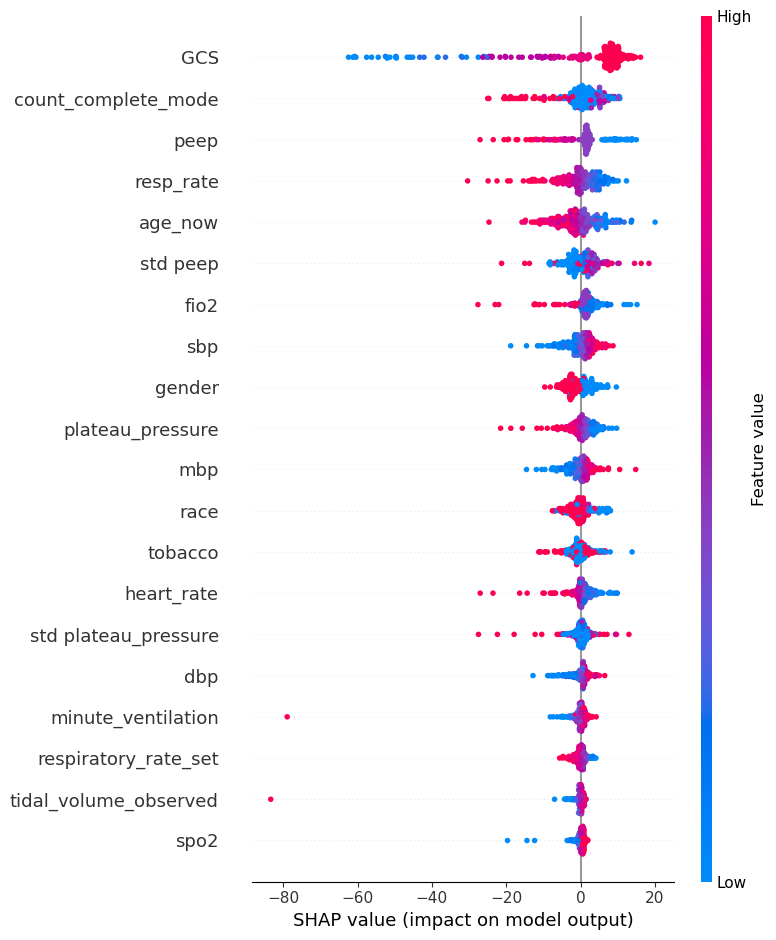

In [20]:
import shap
from keras.models import load_model


from tensorflow.keras.models import load_model
model_test = load_model('./model/modelC_17.h5')
print_score(model_test, X_test,y_test,'test')

# 創建 SHAP 解釋器，使用 Independent masker
explainer = shap.Explainer(model_test, masker=shap.maskers.Independent(data=X_train), feature_names=['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 'tidal_volume_observed', 'RSBI', 'minute_ventilation','peep', 'fio2', 'respiratory_rate_set', 'plateau_pressure','age_now','gender', 'race','BMI', 'tobacco','BMI','GCS','count_complete_mode','std peep','std plateau_pressure'])

# 提供一個樣本數據（X）以生成 SHAP 值
shap_values = explainer.shap_values(X_test)

# 生成 SHAP 圖表
shap.summary_plot(shap_values, X_test, feature_names=['heart_rate', 'sbp', 'dbp', 'mbp', 'spo2', 'resp_rate', 
             'tidal_volume_observed', 'RSBI', 'minute_ventilation','peep',
              'fio2', 'respiratory_rate_set', 'plateau_pressure','age_now','gender', 
               'race'
                ,'BMI', 'tobacco','BMI','GCS','count_complete_mode','std peep','std plateau_pressure'])